In [43]:
from math_verify import parse, verify
import re
import pandas as pd
import torch
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px

In [2]:
df = pd.read_parquet("../../open-math-reasoning/qwen3_8b_sample_1k_outputs/sample_1k_res_qwen3_8b_rep_32.parquet")
prompt_to_embed = torch.load("../../open-math-reasoning/qwen3_8b_sample_1k_outputs/sample_1k_problem_last_hidden_states.pt")
problem_to_all_layer_embed = {key.split("<|im_start|>user\n")[-1].split("<|im_end|>\n<|im_start|>assistant\n")[0]: value for key, value in prompt_to_embed.items()}

In [6]:
min_len = 1000000
short_prompt = None
for prompt in prompt_to_embed.keys():
    if len(prompt) < min_len:
        short_prompt = prompt
        min_len = len(prompt)

short_prompt

'<|im_start|>user\nEvaluate $81^{3/4}$.<|im_end|>\n<|im_start|>assistant\n<think>\n\n'

In [18]:
# layer = -1
# problem_to_embed = {key: value[layer] for key, value in problem_to_all_layer_embed.items()}
problem_to_embed = problem_to_all_layer_embed

In [8]:
def extract_last_boxed_greedy(text):
    if not text:
        return None

    positions = [m.start() for m in re.finditer(r'\\boxed\{', text)]
    if not positions:
        return None

    last_pos = positions[-1]
    rest_of_text = text[last_pos:]
    match = re.match(r'\\boxed\{((?:[^{}]|\{[^{}]*\})*)\}', rest_of_text)
    if match:
        return match.group(1)

    return None

In [11]:
problem_to_pass_rate = {}
for problem in tqdm(df.problem.unique()):
    df_problem = df[df.problem == problem]
    gold = parse(df_problem.expected_answer.tolist()[0])
    num_pass = 0
    num_total = 0
    for response in df_problem.response:
        num_total += 1
        if verify(gold, parse(extract_last_boxed_greedy(response))):
            num_pass += 1
    problem_to_pass_rate[problem] = num_pass / num_total

100%|██████████| 983/983 [02:16<00:00,  7.21it/s]


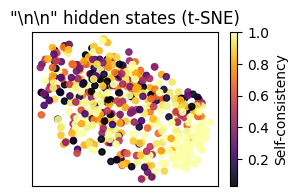

In [40]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

X = torch.stack([problem_to_embed[problem] for problem, pass_rate in problem_to_pass_rate.items() if pass_rate>0])
y = torch.tensor([problem_to_pass_rate[problem]  for problem, pass_rate in problem_to_pass_rate.items() if pass_rate>0])

# t-SNE 降维
tsne = TSNE(n_components=2, perplexity=50, learning_rate='auto', random_state=666, max_iter=5000)
X_2d = tsne.fit_transform(X)

plt.figure(figsize=(3, 2))
plt.tight_layout(pad=0)
sc = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='inferno', s=20, alpha=0.9)
plt.colorbar(sc, label="Self-consistency")
plt.title(""""\\n\\n" hidden states (t-SNE)""")
# remove tick labels
plt.xticks([])
plt.yticks([])
plt.show()

In [55]:
embed_to_pass_rate = {
    problem_to_embed[problem]: pass_rate for problem, pass_rate in problem_to_pass_rate.items() if pass_rate>0
}
torch.save(embed_to_pass_rate, "adapter_trainset.pt")

In [54]:
embed_to_pass_rate

{tensor([-0.4275, -2.1641, -0.3457,  ..., -0.9146, -0.4590, -1.6924],
        dtype=torch.float16): 0.34375,
 tensor([-0.5737, -2.5586, -0.5654,  ..., -1.2979, -0.0637, -1.5918],
        dtype=torch.float16): 0.9375,
 tensor([-0.4382, -1.8174, -0.9824,  ...,  0.3364, -0.8799, -1.4375],
        dtype=torch.float16): 0.1875,
 tensor([-0.6733, -2.4082, -0.7217,  ..., -0.6851, -0.1199, -2.1426],
        dtype=torch.float16): 0.40625,
 tensor([-0.7959, -2.2891, -1.1084,  ..., -0.6118, -0.5830, -2.1953],
        dtype=torch.float16): 0.90625,
 tensor([-0.4314, -2.2773, -0.7070,  ..., -1.2002, -0.1066, -2.3867],
        dtype=torch.float16): 0.9375,
 tensor([-0.3254, -1.3740,  0.2284,  ..., -0.5859, -0.6504, -2.0742],
        dtype=torch.float16): 1.0,
 tensor([-0.6064, -2.3223, -1.2715,  ..., -0.5527, -0.7036, -2.2227],
        dtype=torch.float16): 0.625,
 tensor([-0.0390, -2.6602, -1.0469,  ..., -1.2578, -0.4417, -1.6123],
        dtype=torch.float16): 0.4375,
 tensor([-0.7070, -2.4805, -0